# Matrix Factorization의 SGD 구현
- sgd 최적화를 이용해 mf 모델의 파라미터를 업데이트한다.
- 유저, 아이템 bias까지 추가된 모델로 구현해본다.

## 학습 데이터 준비

In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633983 sha256=36decbc0b963d045d1b644d7ff4b16f8310154eca602e484d8b89da7c0616cea
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm
from surprise import KNNBasic, KNNWithMeans, SVD
from surprise.model_selection.validation import cross_validate
from IPython.display import Image
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/recomm_study/recomm_code/Recommend_learningspoons/data/ml-latest-small-20220921T022859Z-001/ml-latest-small/'
ratings_df = pd.read_csv(path + 'ratings.csv', encoding='utf-8')
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


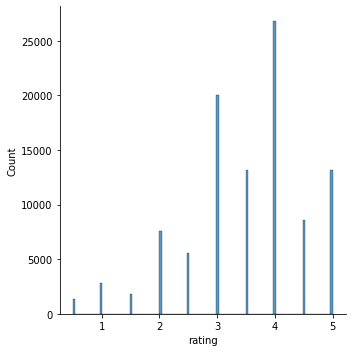

In [4]:
sns.displot(ratings_df['rating'])

## MF 구현

In [5]:
# 학습데이터, 하이퍼파라미터 초기화(initialize)
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)
R = user_item_matrix.to_numpy()
k=20
learning_rate=0.01
regularization=0.2
iterations=20

num_users, num_items = user_item_matrix.shape

In [6]:
# 학습 파라미터 초기화
# 평균이 0, 표준편차는 1/K로 랜덤하게 초기화
# user, item 별 bias 및 전체 bias

P = np.random.normal(scale=1./k, size=(num_users, k))
Q = np.random.normal(scale=1./k, size=(num_items, k))

b_u = np.zeros(num_users)
b_i = np.zeros(num_items)
b = np.mean(R[np.where(R != 0)])

print(R.shape)

(610, 9724)


In [7]:
# 학습 데이터 구성
# 실제 평가를 내린 데이터만을 학습에 사용함
samples = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]
print(len(samples))  # 총 학습 데이터 사이즈

100836


- Parameter Update
![ab](https://i.ibb.co/QCgV5Ys/svd-sgd.png)

In [8]:
# SGD를 활용한 Parameters 업데이트
training_result = []

for epoch in range(iterations):
  # 학습 데이터 shuffle
  np.random.shuffle(samples)

  for i, j, r in samples:
    # 현재 주어진 Parameter로 예측 평점을 구함
    pred = b + b_u[i] + b_i[j] + P[i, :].dot(Q[j, :].T)

    # 실제 평점과 예측 평점 간 차이 = error
    e = (r - pred)

    # user, item 편향 parameter를 업데이트
    b_u[i] += learning_rate * (e - regularization * b_u[i])
    b_i[j] += learning_rate * (e - regularization * b_i[j])

    # user, item 잠재 행렬 parameter를 업데이트
    P[i, :] += learning_rate * (e * Q[j, :] - regularization * P[i, :])
    Q[j, :] += learning_rate * (e * P[i, :] - regularization * Q[j, :])
  
  # 학습 끝난 후 train 데이터로 training loss 계산
  ut, it = R.nonzero()
  pred_R = b + b_u[:, np.newaxis] + b_i[np.newaxis:, ] + P.dot(Q.T)
  error = []

  for x, y in zip(ut, it):
    error.append(pow(R[x, y] - pred_R[x, y], 2))
  rmse = np.sqrt(np.asarray(error).mean())
  print(epoch+1, rmse)
  training_result.append([epoch+1, rmse])

training_result_pd = pd.DataFrame(training_result, columns=['iteration', 'rmse'])

1 0.8980988726713219
2 0.8766774940122313
3 0.8650843838028488
4 0.8576938490358683
5 0.8518144744597772
6 0.8472899815297918
7 0.8438578178696823
8 0.8406968194047477
9 0.8375095266331639
10 0.8351626429438636
11 0.8322956614981657
12 0.8311669847035591
13 0.8296213148791508
14 0.8279553996912807
15 0.8259596464314748
16 0.8254744948087834
17 0.8242361785703566
18 0.8227714980594193
19 0.8214026581696124
20 0.8201296483898312


## MF Class

In [14]:
# 위에서 구한 MF - SGD를 Class 형태로 만듦

class MF():

  def __init__(self, R, K, learning_rate, regularization, iterations):
    '''
    R(ndarray) : user-item matrix
    K(int) : latent factor 차원
    '''
    self.R = R
    self.num_users, self.num_items = R.shape
    self.K = K
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.iterations = iterations
  

  def train(self):

    # user, item 잠재 요인 행렬 및 편향 초기화
    self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
    self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
    self.b_u = np.zeros(self.num_users)
    self.b_i = np.zeros(self.num_items)
    self.b = np.mean(self.R[np.where(self.R != 0)])

    # 학습 데이터 생성
    self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
    ]

    # iteration 횟수만큼 전체 데이터에 대해 SGD
    training_process = []
    for i in range(self.iterations):
      np.random.shuffle(self.samples)
      self.sgd()
      rmse = self.rmse()
      training_process.append((i, rmse))
      
      if (i+1) % 10 == 0:
        print(f'iteration : {i+1} / error = {np.round(rmse,4)}')
    
    return pd.DataFrame(training_process, columns=['iteration', 'rmse'])
  

  def rmse(self):
    ut, it = self.R.nonzero()   # user와 item 중 0이 아닌 값의 인덱스를 반환
    predicted_R = self.full_matrix()
    error = []

    for x, y in zip(ut, it):
      error.append(pow(R[x, y] - predicted_R[x, y], 2))
    
    return np.sqrt(np.asarray(error).mean())
  
  
  def sgd(self):
    
    for i, j, r in self.samples:
      prediction = self.get_rating(i, j)
      e = (r - prediction)

      # 편향 및 전체 잠재요인 행렬 업데이트
      self.b_u[i] += self.learning_rate * (e - self.regularization * self.b_u[i])
      self.b_i[j] += self.learning_rate * (e - self.regularization * self.b_i[j])
      self.P[i, :] += self.learning_rate * (e * self.Q[j, :] - self.regularization * self.P[i, :])
      self.Q[j, :] += self.learning_rate * (e * self.P[i, :] - self.regularization * self.Q[j, :])
  
  
  def get_rating(self, i, j):
    '''
    user i, item j 에 대한 예측 평점 계산
    '''
    pred = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
    return pred
  
  
  def full_matrix(self):
    '''
    예측된 user-item matrix를 계산
    '''
    return self.b + self.b_u[:, np.newaxis] + self.b_i[np.newaxis:, ] + self.P.dot(self.Q.T)

In [17]:
# 주어진 유저-아이템 매트릭스 sample

R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

mf = MF(R, K=2, learning_rate=0.1, regularization=0.01, iterations=30)

train_result_df = mf.train()
mf.full_matrix()

iteration : 10 / error = 0.0483
iteration : 20 / error = 0.0095
iteration : 30 / error = 0.0096


array([[4.98564658, 2.99696989, 3.4982262 , 1.01242164],
       [3.9938578 , 2.34267286, 3.04922529, 1.01269875],
       [1.00844278, 1.00561272, 4.08275773, 4.98802997],
       [1.0088589 , 1.00058623, 3.44230067, 3.99491659],
       [3.41262305, 1.01335148, 4.99114567, 3.99492005]])

### 무비렌즈 데이터로 학습

In [25]:
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)
R = user_item_matrix.to_numpy()
K = 20
learning_rate = 0.01
regularization = 0.2

mf = MF(R, K, learning_rate, regularization, iterations=70)
train_result_df = mf.train()

iteration : 10 / error = 0.8348
iteration : 20 / error = 0.8201
iteration : 30 / error = 0.8128
iteration : 40 / error = 0.8077
iteration : 50 / error = 0.8026
iteration : 60 / error = 0.7987
iteration : 70 / error = 0.7924


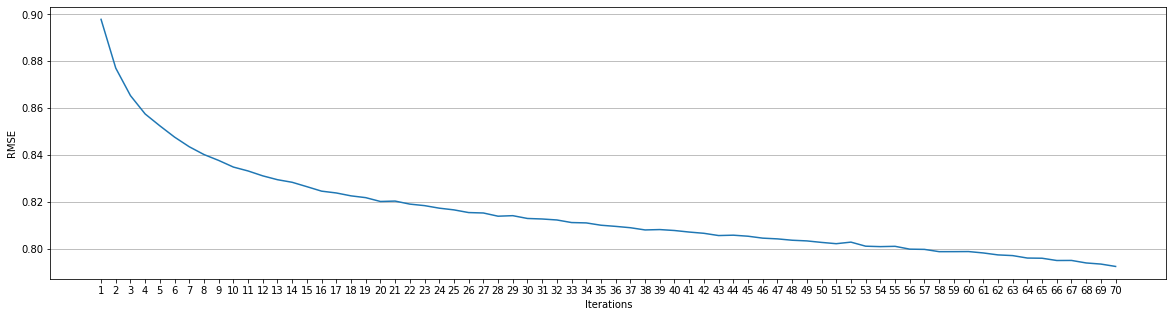

In [26]:
# iteration에 따른 training loss

x = train_result_df.iteration.values + 1
y = train_result_df.rmse.values
plt.figure(figsize=((20,5)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.grid(axis="y")

# Matrix Factorization의 ALS 구현
1. 초기 아이템, 사용자 행렬을 초기화
2. 아이템 행렬을 고정하고 사용자 행렬을 최적화
3. 사용자 행렬을 고정하고 아이템 행렬을 최적화
4. 위의 2, 3 과정을 반복

## ALS 구현

In [27]:
# 유저-아이템 행렬

R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])


In [28]:
# 학습데이터, 하이퍼파라미터 초기화

# 잠재요인 개수
k = 5

# l2 하이퍼파라미터
regularization = 0.01
num_users, num_items = R.shape

# ALS 업데이트 횟수
iterations = 100

In [29]:
# 유저, 아이템 잠재요인 매트릭스

users = np.random.normal(scale=1./k, size=(num_users, k))
items = np.random.normal(scale=1./k, size=(num_items, k))

In [30]:
items.shape

(5, 5)

- ALS 업데이트 수식
![수식](https://i.ibb.co/Csh6Yb0/2021-06-25-10-50-03.png)

In [33]:
# iteration마다 위 수식을 활용해 user, item 행렬 업데이트
# 참고: https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html

training_process = []

for epoch in range(iterations):

  for i, Ri in enumerate(R):
    # 위 수식 중 첫번째 식
    users[i] = np.linalg.solve(np.dot(items.T, items) + regularization * np.eye(k), \
                               np.dot(items.T, R[i].T)).T

  for j, Rj in enumerate(R.T):
    items[j] = np.linalg.solve(np.dot(users.T, users) + regularization * np.eye(k), \
                               np.dot(users.T, R[:, j]))
  
  cost = 0
  xi, yi = R.nonzero()

  for x, y in zip(xi, yi):
    cost += pow(R[x, y] - users[x, :].dot(items[y, :].T), 2)
  
  cost = np.sqrt(cost / len(xi))
  training_process.append((epoch, cost))

  if (epoch + 1) % 10 == 0:
    print(f'Iteration : {epoch + 1} / cost = {np.round(cost,4)}')
    

Iteration : 10 / cost = 0.0008
Iteration : 20 / cost = 0.0011
Iteration : 30 / cost = 0.0014
Iteration : 40 / cost = 0.0016
Iteration : 50 / cost = 0.0018
Iteration : 60 / cost = 0.002
Iteration : 70 / cost = 0.0021
Iteration : 80 / cost = 0.0023
Iteration : 90 / cost = 0.0024
Iteration : 100 / cost = 0.0025


In [34]:
R

array([[1, 0, 0, 1, 3],
       [2, 0, 3, 1, 1],
       [1, 2, 0, 5, 0],
       [1, 0, 0, 4, 4],
       [2, 1, 5, 4, 0],
       [5, 1, 5, 4, 0],
       [0, 0, 0, 1, 0]])

In [35]:
# 예측 행렬
R_hat = users.dot(items.T)
R_hat

array([[ 9.99018421e-01, -4.74932669e-03, -2.79412190e-06,
         1.00227579e+00,  2.99630428e+00],
       [ 1.99989036e+00, -1.02225201e-03,  2.99826788e+00,
         1.00134881e+00,  9.98462927e-01],
       [ 9.99800714e-01,  1.99528639e+00,  1.74413225e-03,
         4.99847127e+00,  8.55036944e-04],
       [ 1.00077327e+00,  4.54565033e-03,  7.85190428e-04,
         3.99759840e+00,  3.99834880e+00],
       [ 2.00478180e+00,  9.99263305e-01,  4.99612726e+00,
         3.99915158e+00, -5.31087901e-04],
       [ 4.99449382e+00,  1.00146245e+00,  5.00094647e+00,
         3.99982275e+00,  1.73338326e-03],
       [ 3.52100880e-04,  4.17091305e-03,  4.96643981e-04,
         9.97989474e-01,  1.32301045e-03]])

## ALS 클래스

In [51]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

class AlternatingLeastSquares():

  def __init__(self, R, k, regularization, iterations, verbose=False):
    '''
    R(ndarray) : user-item 행렬
    k(int) : latent factor 차원
    verbose : 학습과정 출력옵션
    '''
    self.R = R
    self.num_users, self.num_items = R.shape
    self.k = k
    self.regularization = regularization
    self.iterations = iterations
    self.verbose = verbose


  def fit(self):
    # user, item 행렬 initialize
    self.users = np.random.normal(scale=1./k, size=(self.num_users, self.k))
    self.items = np.random.normal(scale=1./k, size=(self.num_items, self.k))

    # iteration 횟수만큼 ALS를 수행 --> user, item 파라미터 업데이트
    self.training_process = []
    for iter in range(self.iterations):
      
      for i, Ri in enumerate(self.R):
        self.users[i] = self.user_latent(i, Ri)
      
      for j, Rj in enumerate(self.R.T):
        self.items[j] = self.item_latent(j, Rj)
      
      # iteration 수행이 끝날때마다 training_loss 계산
      cost = self.cost()
      self.training_process.append((iter, cost))

      # 10번째마다 loss 출력하는 옵션
      if self.verbose == True and ((iter + 1) % 10 == 0):
        print(f'Iteration : {iter + 1} / cost = {np.round(cost,4)}')


  def cost(self):
    '''
    학습 데이터 전체 rmse 계산
    '''
    xi, yi = self.R.nonzero()
    cost = 0
    for x, y in zip(xi, yi):
      cost += pow(self.R[x, y] - self.get_prediction(x, y), 2)
    
    return np.sqrt(cost / len(xi))
  

  def user_latent(self, i, Ri):
    '''
    user i에 대한 user vector 업데이트
    '''
    du = np.linalg.solve(np.dot(self.items.T, self.items) + self.regularization * np.eye(self.k),
                         np.dot(self.items.T, self.R[i].T)).T
    return du
  
  def item_latent(self, j, Rj):
    '''
    item j에 대한 item vector 업데이트
    '''
    di = np.linalg.solve(np.dot(self.users.T, self.users) + self.regularization * np.eye(self.k),
                         np.dot(self.users.T, self.R[:, j]))
    return di
  

  def get_prediction(self, i, j):
    '''
    user i, item j에 대한 예측 평점
    '''
    return self.users[i, :].dot(self.items[j, :].T)
  

  def get_full_matrix(self):
    '''
    예측값을 가진 user-item 행렬을 계산
    '''
    return self.users.dot(self.items.T)

In [53]:
R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

als = AlternatingLeastSquares(R = R, regularization = 0.01, iterations=20, verbose=True, k=5)
als.fit()
als.get_full_matrix()

Iteration : 10 / cost = 0.001
Iteration : 20 / cost = 0.0013


array([[ 1.00058358e+00, -4.05890424e-03, -2.42293252e-04,
         1.00139199e+00,  2.99823123e+00],
       [ 2.00038175e+00, -1.18175097e-03,  2.99943801e+00,
         1.00054937e+00,  9.99259963e-01],
       [ 1.00036197e+00,  1.99714402e+00,  3.88433997e-04,
         5.00019683e+00, -2.54515648e-04],
       [ 9.99697983e-01,  3.29960376e-03,  2.03417951e-04,
         3.99866347e+00,  4.00018201e+00],
       [ 2.00219263e+00,  9.99039886e-01,  4.99852722e+00,
         3.99965850e+00, -8.33623591e-04],
       [ 4.99766001e+00,  1.00169512e+00,  5.00082569e+00,
         3.99994315e+00,  1.18260624e-03],
       [-5.93905301e-04,  3.37743830e-03,  2.93198222e-04,
         9.98814668e-01,  1.03664962e-03]])

In [54]:
als.get_prediction(1, 3)

1.000549370957293

# Surprise에서 제공하는 MF 모델 (SVD)
- 지난 시간에 사용한 Surprsie 패키지에서 추천 모델을 제공한다.
    - Surprise의 SVD는 SGD로 학습되는 MF를 의미한다.
- SGD로 모델이 학습될 때 변경 가능한 옵션과 하이퍼파라미터에 대해서 살펴본다.
- 무비렌즈 데이터를 활용해 KNN 모델과 SVD모델을 각각 학습해보고 추천 성능을 비교해보자.

In [55]:
# surprise에서 제공하는 dataset과 reader

from surprise import Reader, Dataset

reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [56]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# train / test 데이터 나누기
train_data, test_data = train_test_split(data, test_size=0.2, random_state=10)

## SVD Model

- [모델 API 문서](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
- The SVD++ algorithm, an extension of SVD taking into account implicit ratings.

In [57]:
# Surprise 내장된 SVD --> MF - SGD 구현을 Surprise에서는 SVD라고 함
svd_model = SVD(n_factors=20, reg_all=0.02)
svd_model.fit(train_data)
pred = svd_model.test(test_data)
accuracy.rmse(pred)

RMSE: 0.8678


0.8677808295004306

In [58]:
# 유저/아이템 매트릭스

print(svd_model.pu.shape)
print(svd_model.qi.shape)

(610, 20)
(8933, 20)


In [59]:
# 유저 0의 latent factor

svd_model.pu[0]

array([ 0.1588705 ,  0.12363621,  0.15382518,  0.09368264,  0.02815742,
       -0.05528456, -0.0469726 , -0.00602786,  0.10749267,  0.05063749,
        0.02081816,  0.0861277 ,  0.11402767,  0.19594155, -0.1699747 ,
        0.09485573,  0.01687911,  0.02045943,  0.11203011, -0.01991326])

In [60]:
# 아이템 0의 latent factor

svd_model.qi[0]

array([ 0.03588783, -0.2264171 , -0.21786704,  0.10609089,  0.13521547,
       -0.02823582,  0.0879008 ,  0.13312255,  0.24488793, -0.13848405,
       -0.04714434, -0.21987919,  0.11992626,  0.19192532,  0.22303746,
        0.09880849,  0.11225065,  0.21776701, -0.05407651, -0.08479472])

In [61]:
# 평점 예측

user_id = 1
item_id = 1

svd_model.predict(user_id, item_id)

Prediction(uid=1, iid=1, r_ui=None, est=4.569015367111061, details={'was_impossible': False})

In [62]:
# 새로운 유저, 아이템이 등장할 경우 default_prediction를 사용
# default_prediction : train 데이터셋의 전체 평점 평균

user_id = 0
item_id = 0
print(svd_model.predict(user_id, item_id).est)
print(svd_model.default_prediction())

3.5001859473397134
3.5001859473397134


![default_prediction](https://i.ibb.co/6YxrX1s/default-prediction.png)

### [모델 상세 옵션](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

- Rating Function
![ab](https://i.ibb.co/MSZJKLp/svd-rating.png)
- Objective Function
![ab](https://i.ibb.co/DzMmtyx/svd-obj.png)

In [63]:
# bias 옵션 유무에 따른 성능 비교
# default = True

for biased in [False, True]:
    svd_model = SVD(biased=biased)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('biased:', biased, ',', accuracy.rmse(predictions))


RMSE: 0.9842
biased: False , 0.9842059583809085
RMSE: 0.8699
biased: True , 0.8698725028880845


In [64]:
# latent factor 수에 따른 성능 비교
# default = 100

for k in [25, 50, 100, 150]:
    svd_model = SVD(n_factors=k)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('n_factors:', k, ',', accuracy.rmse(predictions))


RMSE: 0.8656
n_factors: 25 , 0.8656279208610022
RMSE: 0.8688
n_factors: 50 , 0.8688242767612409
RMSE: 0.8708
n_factors: 100 , 0.8707745272061986
RMSE: 0.8746
n_factors: 150 , 0.8745748498715404


In [65]:
# learning rate에 따른 성능 비교
# default = 0.005

for lr_all in [.0025, .005, .001]:
    svd_model = SVD(lr_all=lr_all)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('lr_all:', lr_all, ',', accuracy.rmse(predictions))


RMSE: 0.8792
lr_all: 0.0025 , 0.8792196165857271
RMSE: 0.8688
lr_all: 0.005 , 0.8687741484297733
RMSE: 0.8954
lr_all: 0.001 , 0.8953653100957262


In [66]:
# regularization에 따른 성능 비교
# default = 0.02

for reg_all in [0, 0.02, 0.1, 1]:
    svd_model = SVD(reg_all=reg_all)
    svd_model.fit(train_data)
    predictions = svd_model.test(test_data)

    # Then compute RMSE
    print('reg_all:', reg_all, ',', accuracy.rmse(predictions))


RMSE: 0.8935
reg_all: 0 , 0.8935285008248894
RMSE: 0.8708
reg_all: 0.02 , 0.8708241896387828
RMSE: 0.8674
reg_all: 0.1 , 0.8674074518999164
RMSE: 0.9051
reg_all: 1 , 0.9050990620476979


In [67]:
# GridSearch 패키지로 최적 파라미터 탐색
from surprise.model_selection import GridSearchCV

param_grid = {'lr_all' : [0.0025, 0.005],
               'n_factors' : [25, 50, 100],
               'reg_all' : [0.02, 0.1, 0.2]
               }

gs = GridSearchCV(SVD, param_grid, measures=['RMSE'], cv=2, n_jobs=-1)
gs.fit(data)

print(gs.best_score)
print(gs.best_params)

{'rmse': 0.8823610483744262}
{'rmse': {'lr_all': 0.005, 'n_factors': 25, 'reg_all': 0.1}}


In [68]:
pd.DataFrame(gs.cv_results).sort_values(by='rank_test_rmse')

,split0_test_rmse,split1_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_lr_all,param_n_factors,param_reg_all
10,0.880625,0.884097,0.882361,0.001736,1,2.670058,0.076659,0.849056,0.000657,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.10
13,0.880551,0.884838,0.882695,0.002144,2,4.907610,0.053493,0.943859,0.136338,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.10
16,0.881179,0.885098,0.883139,0.001960,3,8.272666,0.232646,0.818961,0.007260,"{'lr_all': 0.005, 'n_factors': 100, 'reg_all':...",0.0050,100,0.10
9,0.882481,0.885619,0.884050,0.001569,4,2.957443,0.469554,0.964563,0.050448,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.02
11,0.882853,0.886852,0.884853,0.001999,5,2.600652,0.118093,0.886375,0.075735,"{'lr_all': 0.005, 'n_factors': 25, 'reg_all': ...",0.0050,25,0.20
14,0.883091,0.887103,0.885097,0.002006,6,4.782388,0.190216,1.357630,0.175827,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.20
17,0.883393,0.887496,0.885445,0.002051,7,6.096393,1.332923,0.522235,0.140244,"{'lr_all': 0.005, 'n_factors': 100, 'reg_all':...",0.0050,100,0.20
12,0.884227,0.887889,0.886058,0.001831,8,4.109534,0.350845,0.978236,0.017538,"{'lr_all': 0.005, 'n_factors': 50, 'reg_all': ...",0.0050,50,0.02
0,0.888665,0.891717,0.890191,0.001526,9,2.591130,0.182018,0.894093,0.064928,"{'lr_all': 0.0025, 'n_factors': 25, 'reg_all':...",0.0025,25,0.02
1,0.888919,0.892139,0.890529,0.001610,10,2.778621,0.217420,0.875408,0.049580,"{'lr_all': 0.0025, 'n_factors': 25, 'reg_all':...",0.0025,25,0.10


## 예측 모델 간의 성능 비교

- 지난시간에 배운 KNN과 MF(SVD) 사이의 모델 성능을 비교해보자

In [69]:
# KNN 모델

sim_options = {
    'name': 'msd',
    'user_based': False
}

knn = KNNWithMeans(k = 40, min_k = 1, sim_options = sim_options)

cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8971  0.8926  0.8915  0.8930  0.8955  0.8939  0.0021  
MAE (testset)     0.6826  0.6841  0.6861  0.6788  0.6848  0.6833  0.0025  
Fit time          8.49    6.70    6.91    5.34    5.80    6.65    1.09    
Test time         9.57    12.08   9.63    9.30    9.35    9.99    1.05    


{'test_rmse': array([0.89709305, 0.89260484, 0.89148062, 0.8929919 , 0.8955471 ]),
 'test_mae': array([0.68259487, 0.68412823, 0.68607984, 0.67880213, 0.68477017]),
 'fit_time': (8.491233348846436,
  6.703519344329834,
  6.909701108932495,
  5.339433431625366,
  5.8024256229400635),
 'test_time': (9.5669264793396,
  12.075078248977661,
  9.632015705108643,
  9.302186727523804,
  9.352173089981079)}

In [70]:
# SVD 모델

svd = SVD(n_factors=25, lr_all=0.005, reg_all=0.1)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8715  0.8743  0.8676  0.8725  0.8715  0.8715  0.0022  
MAE (testset)     0.6706  0.6742  0.6672  0.6710  0.6687  0.6704  0.0024  
Fit time          2.50    2.58    2.58    2.50    2.79    2.59    0.11    
Test time         0.14    0.36    0.14    0.35    0.26    0.25    0.10    


{'test_rmse': array([0.87154035, 0.87425433, 0.86763955, 0.87245905, 0.8714998 ]),
 'test_mae': array([0.67059595, 0.67419463, 0.66721555, 0.67102746, 0.66873428]),
 'fit_time': (2.496162176132202,
  2.584650754928589,
  2.5834896564483643,
  2.5024983882904053,
  2.790818452835083),
 'test_time': (0.1418602466583252,
  0.35814476013183594,
  0.1422879695892334,
  0.3502929210662842,
  0.2595329284667969)}